<a href="https://colab.research.google.com/github/kunai-3txk/Prediction-of-seriously-ill-patients/blob/main/BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [2]:
!pip install catboost
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 21.2 MB/s eta 0:00:00


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import os

import warnings
warnings.filterwarnings("ignore", message="Device used : cpu", category=UserWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import polars as pl

import xgboost as xgb
import seaborn as sns; sns.set()


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb #LightGBM
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,Pool

#config

In [165]:
class config:
    RANDOM_STATE=100  
    FRAC = 0.2
    N_FOLD = 5
    N_BAGGING = 3
    UNDER_SAMPLING = True
    
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/ill"
    
    SUBMISSION = common_path + "/submission.csv"
    TRAIN = common_path + "/train_df.csv"
    TEST = common_path + "/test_df.csv"
    SUB_OUT = common_path + "/sub/"
     

#def

#Load Data

In [172]:
train = pd.read_csv(paths.TRAIN)
print('train shape:',train.shape)

test = pd.read_csv(paths.TEST)
print('test shape:',test.shape)

submission = pd.read_csv(paths.SUBMISSION)
print('submission shape:',submission.shape)

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,...,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,body_system_1,body_system_2,target_label
0,0,114501,58009,51,69.0,24.731460,0,1.0,Caucasian,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
1,1,44353,112590,19,64.0,28.666129,0,1.0,Caucasian,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0
2,2,8023,1677,16,74.0,18.144869,0,0.0,Caucasian,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
3,3,106340,74166,188,60.0,23.047667,0,0.0,Caucasian,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
4,4,118467,52717,168,75.0,20.190265,0,0.0,Caucasian,F,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Gastrointestinal,Gastrointestinal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51354,51354,88819,81966,64,67.0,20.622289,1,0.0,Caucasian,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal,0
51355,51355,45825,3470,161,63.0,35.054523,0,0.0,Caucasian,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
51356,51356,92992,109497,133,73.0,24.920113,0,0.0,Caucasian,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
51357,51357,29502,72376,54,69.0,27.202393,1,0.0,Native American,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0


#EDA

In [184]:
# 世代のtarget_encoding
t = train[['age','target_label']]
t['age_r'] = t['age'].round(-1)
t.groupby('age_r').mean()

train[['x5','target_label']].describe()

,x5,target_label
count,46864.000000,51359.000000
mean,0.086122,0.086295
std,0.248953,0.280801
min,-1.000000,0.000000
25%,0.020000,0.000000
50%,0.050000,0.000000
75%,0.130000,0.000000
max,0.980000,1.000000


# Data Clean

In [ ]:
#train.info()

In [159]:
target_col = ['target_label']

num_cols = ['age', 'bmi', 'height', 'weight', 'icu_4', 'icu_6',  'glasgow_coma_scale_1', 'glasgow_coma_scale_2',
            'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure',
            'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4',
            'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14',
            'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14',
            'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# id, personal_id_1, personal_id_2 以外のカテゴリー変数
whole_cat_cols = [c for c in test.columns if c not in num_cols and c not in ['id', 'personal_id_1', 'personal_id_2']]

#for c in whole_cat_cols:
#  print(c,":",train[c].nunique())

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in whole_cat_cols:
    nunq = train[c].nunique()
    if nunq >= 10:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)

for c in low_cat_cols:
    print(f"{c}:\t{train[c].unique()}")
for c in high_cat_cols:
    print(f"{c}:\t{train[c].unique()}")


print(high_cat_cols)
print(low_cat_cols)

facility_id:	[ 51  19  16 188 168 200 111  18  80 161 196  55 176  30 157 137  98 169
 150 112 128  33  43  39  79 194   5  62  49 109 116   2 119  63 133  13
 113 103  32  83 118  70 185  21 149 101 166 100  27 160 132  76 117  26
 105  54  10 138 192  14  77  24  57  40 155 186  69 174  90 187  99  64
  35 147 180 171 204 167  89 198 140 107 189 181 202  93 146   6   8 151
 136  92 199  47  31 158 159 135  60  50 121 139  15 195 182  37  17  78
  81 125  85  53 184 142 177 104  36  94  71  87 102  72 179 197  84  88
 145  46  44 134   9  20  91  34 183  29   3  68 129 130  23  66  74  38
 124   4  95]
icu_id:	[698 657 482 855 136 516 602 775 620 324 809 376 622 921 697 143 267 252
 160 384 377 623  91 642 619 402 413 601 337 261 646 467 888 432 307 876
 417 108 889 549 694 120 798 369  95  99 434 664 687 513 103 481 504 613
 464 675 477 841 491 840 831 711 679 608 470 347 772 499 391 285 424 550
 259 480  97 425 708  92 102 251 647 489 829 114 100  87 523 487  85 628
 609 678 700 451

In [161]:
# Label Encoding用の辞書
# uniqueが0,1,nanだけの場合は不要
ethnicity_list = train['ethnicity'].value_counts().sort_values(ascending=False).index
ethnicity_dic = dict(zip(ethnicity_list, range(len(ethnicity_list))))

gender_dic = {'M':0, 'F':1}

icu1_list = train['icu_1'].value_counts().sort_values(ascending=False).index
icu1_dic = dict(zip(icu1_list, range(len(icu1_list))))

icu2_list = train['icu_2'].value_counts().sort_values(ascending=False).index
icu2_dic = dict(zip(icu2_list, range(len(icu2_list))))

icu3_list = train['icu_3'].value_counts().sort_values(ascending=False).index
icu3_dic = dict(zip(icu3_list, range(len(icu3_list))))

icu5_list = train['icu_5'].value_counts().sort_values(ascending=False).index
icu5_dic = dict(zip(icu5_list, range(len(icu5_list))))

# 'body_system_1 と 'body_system_1 はその組み合わせに対してLabel Encoding
_ser = train['body_system_1'].fillna('NA') + '_' + train['body_system_2'].fillna('NA')
bs_list = _ser.value_counts().sort_values(ascending=False).index
bs_dic = dict(zip(bs_list, range(len(bs_list))))

# Count Encoding用にvalue_countsを用意(辞書として使う)
vc_facility = train['facility_id'].value_counts()
vc_icu = train['icu_id'].value_counts()

In [168]:
def base_encoder(input_df):
    out_df = input_df[num_cols].copy()

    #Label Encoding
    out_df['LE_situation_1'] = input_df['situation_1'].copy()
    out_df['LE_situation_2'] = input_df['situation_2']
    out_df['LE_ethnicity'] = input_df['ethnicity'].map(ethnicity_dic)
    out_df['LE_gender'] = input_df['gender'].map(gender_dic)
    out_df['LE_icu_1'] = input_df['icu_1'].map(icu1_dic)
    out_df['LE_icu_2'] = input_df['icu_2'].map(icu2_dic)
    out_df['LE_icu_3'] = input_df['icu_3'].map(icu3_dic)
    out_df['LE_icu_5'] = input_df['icu_5'].map(icu5_dic)
    out_df['LE_icu_7'] = input_df['icu_7'].copy()
    out_df['LE_icu_8'] = input_df['icu_8']
    out_df['num_disease'] = 0   # 持病の数
    for c in ['aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']:
        out_df['LE_'+c] = input_df[c]
        out_df['num_disease'] += input_df[c]
    out_df['body_system'] = input_df['body_system_1'].fillna('NA') + '_' + input_df['body_system_2'].fillna('NA')
    out_df['LE_body_system'] = out_df['body_system'].map(bs_dic)
    out_df['CE_facility'] = input_df['facility_id'].map(vc_facility)
    out_df['CE_icu'] = input_df['icu_id'].map(vc_icu)
    
    #不要行の削除
    out_df.drop('body_system', axis=1,inplace=True)

    #return out_df.drop('body_system', axis=1)
    return out_df

In [ ]:
#train[train[target_col]==0].count()

## target_encoding

In [163]:
# Target Encoding用のDataFrameを用意
te_base_train = train[['facility_id', 'icu_id', 'target_label']].copy()
te_base_test = test[['facility_id', 'icu_id']].copy()

def target_encoder(col, min_thres, train_idx, valid_idx):
    '''
    Target Encoding用の関数
    col はfacility_id, icu_idのいずれか
    min_thresはTarget Encodingする最小個数
    '''
    te_train = te_base_train.loc[train_idx]
    te_valid = te_base_train.loc[valid_idx]
    te_test = te_base_test.copy()

    # te_trainにmin_thres以上の個数がある値だけをTarget Encodingの対象にする
    # 少数のデータで極端な値になることを防ぐため
    vc = te_train[col].value_counts()
    value_target = vc[vc>=min_thres].index 

    gb = te_train.groupby(col)['target_label'].mean()

    te_train['TE_'+col] = te_train[col].apply(lambda x: gb[x] if x in value_target else np.nan)
    te_valid['TE_'+col] = te_valid[col].apply(lambda x: gb[x] if x in value_target else np.nan)
    te_test['TE_'+col] = te_test[col].apply(lambda x: gb[x] if x in value_target else np.nan)

    return te_train['TE_'+col], te_valid['TE_'+col], te_test['TE_'+col]

#Fit

## prepro

In [169]:
X_train = base_encoder(train)
y_train = train['target_label']

test_X = base_encoder(test)

models = []                     
preds = np.zeros(len(test))
scores = 0.0   
best_score = -1
fi_df = pd.DataFrame()
oof = np.zeros(len(X_train))

#_train, X_valtest, y_train, y_valtest = train_test_split(train_X,train_y,test_size=config.FRAC,random_state=config.RANDOM_STATE)
skf = StratifiedKFold(n_splits=config.N_FOLD, shuffle=True, random_state=config.RANDOM_STATE)

In [ ]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)): 
  X_trn, y_trn = X_train.loc[trn_idx], y_train[trn_idx]
  X_val, y_val = X_train.loc[val_idx], y_train[val_idx]

  #target_encoding
  te_fac_train, te_fac_valid, te_fac_test = target_encoder('facility_id', 5, trn_idx, val_idx)
  te_icu_train, te_icu_valid, te_icu_test = target_encoder('icu_id', 5, trn_idx, val_idx)

  X_trn = pd.concat([X_trn, te_fac_train, te_icu_train], axis=1)
  X_val = pd.concat([X_val, te_fac_valid, te_icu_valid], axis=1)
  test_X_te = pd.concat([test_X, te_fac_test, te_icu_test], axis=1)

  for bag in range(config.N_BAGGING):

    rus = RandomUnderSampler(random_state=config.RANDOM_STATE, replacement=True)
    if config.UNDER_SAMPLING:
      X_trn, y_trn = rus.fit_resample(X_trn, y_trn)

    # モデルの学習
    #model = lgb.LGBMClassifier(importance_type='gain')
    model = lgb.LGBMClassifier(n_estimators=30000,
    max_depth=5,
    colsample_bytree=0.5,
    learning_rate=0.06,
    importance_type='gain',
    random_state=config.RANDOM_STATE)
    model.fit(X_trn, y_trn
              ,eval_metric='auc' 
              ,eval_set=[(X_val, y_val)]
              ,callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
              )

    # validation データでの予測結果
    score = roc_auc_score(y_val,model.predict_proba(X_val)[:,1])
    oof[val_idx] = model.predict_proba(X_val)[:,1]
    #scores += score / (config.N_FOLD * config.N_BAGGING)
    models.append(model)

    if score > best_score:
        best_score = score
        best_model = model
        best_fold = fold+1
        best_bag = bag+1

    

      # feature_importances_の記録
    _df = pd.DataFrame()
    _df['feature'] = X_trn.columns
    _df['FI'] = model.feature_importances_
    _df['fold'] = fold
    _df['bag'] = bag
    fi_df = pd.concat([fi_df, _df])

    preds += model.predict_proba(test_X_te)[:,1] / (config.N_FOLD * config.N_BAGGING)

    #print("Fold :" , fold+1,"Bagging:",bag+1)

  print("Fold :" , fold+1)

print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold,"BAG",best_bag)
tot_auc = roc_auc_score(y_train, oof)
print(f"Overall AUC: {tot_auc:.5f}")

## feature_importances

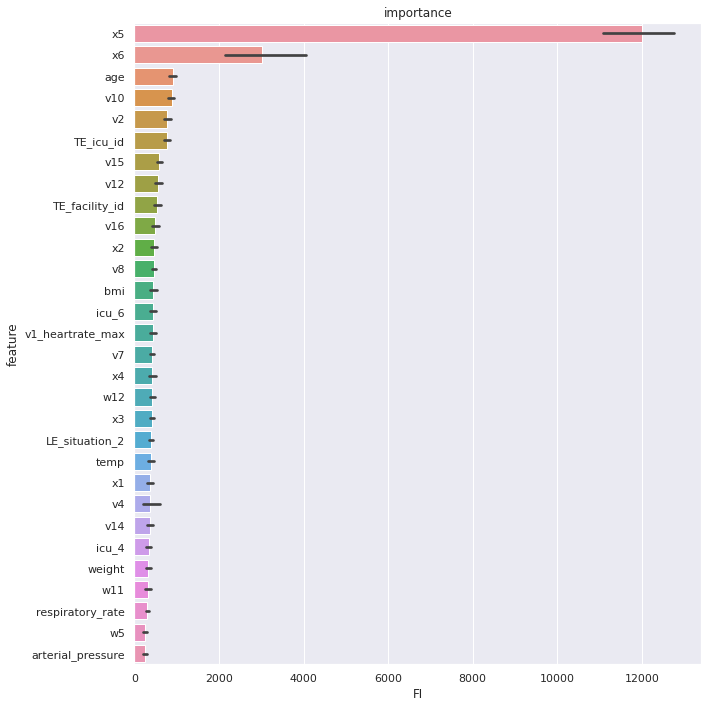

In [174]:
# feature_importances_ 上位20個の図示
TOP = 30

order = fi_df.groupby('feature')['FI'].mean().sort_values(ascending=False)[:TOP].index
# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x="FI",y="feature",data=fi_df,order=order)
plt.title('importance')
plt.tight_layout()
plt.show()

##displot

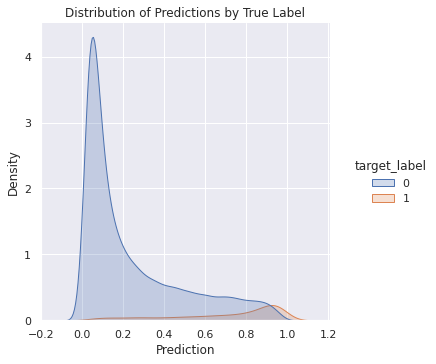

In [157]:
oof_df = pd.DataFrame({
    'oof': oof,
    'target_label':train['target_label']
})

# 'target_label'ごとの予測値の分布を可視化する
sns.displot(oof_df, x="oof", hue="target_label", kind="kde", fill=True)

# グラフのタイトルと軸ラベルを設定する
plt.title('Distribution of Predictions by True Label')
plt.xlabel('Prediction')
plt.ylabel('Density')

# グラフを表示する
plt.show()

In [155]:
submission['target_label'] = preds
submission.to_csv(paths.SUB_OUT+'submission.csv', index=False)